In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from xgboost import XGBClassifier
from joblib import dump, load

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [343]:
#loading
df = pd.read_csv('train_sample_final.csv', sep=';', decimal=',')
sorted_df = df.sort_values(by=['Класс'], ascending=True, ignore_index=True)
x = sorted_df.copy(deep=True)
y = sorted_df.copy(deep=True)
y = y['Класс']

def sampling(x_full, class_number):
    x_sample = x_full.copy(deep=True)
    for index in range(0,len(x_sample)):
        if (x_sample['Класс'][index] != class_number):
            x_sample.drop(index, inplace=True)
    return x_sample

def choices_for_range(weights_list, begin, mid1, mid2, end):    
    flg = random.choices([1,2,3],weights_list)[0]
    if (flg == 1):
        output = random.randint(begin,mid1-1)
    if (flg == 2):
        output = random.randint(mid1,mid2)
    if (flg == 3):
        output = random.randint(mid2+1,end)
    return output

x_normal = sampling(x, 0)
x_alert = sampling(x, 1)
x_pat = sampling(x, 2)
print(len(x_normal), len(x_alert), len(x_pat))

5 16 36


In [115]:
#normal values generation
def NVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота, тошнота, количество рвотных позвывов за день, признаки орви 
        for zero in range(4):
            sample.append(0)
        #температура тела, сатурация
        sample.append(choices_for_range([1,5,1],362,364,368,369)/10)
        sample.append(random.randint(97,99))
        #BLD
        sample.append(0)
        #KET, LEU
        for ketleu_iter in range(2):
            if (trimester == 1):
                sample.append(random.randint(0,1)) 
            else:
                sample.append(0)
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(0)
        else:
            sample.append(random.choices([0,1],[5,1])[0])
        #NIT
        sample.append(0) 
        #URO, BIL, VC
        sample.append(random.randint(0,1))
        for bilvc_iter in range(2):
            sample.append(0)
        #PRO
        if (trimester == 1):
            sample.append(0)
        else:
            sample.append(random.randint(0,1))
        #PH
        sample.append(random.randint(5,7))
        #SG
        sample.append(random.randint(1010,1035)/1000)
        #АД верхнее
        sample.append(random.randint(100, 130))
        #АД нижнее
        sample.append(random.randint(60, 90))
        #Пульс
        if (trimester == 1):
            sample.append(random.randint(60,80))
        if (trimester == 2):
            sample.append(random.randint(70,90))
        if (trimester == 3):
            sample.append(random.randint(70,100))
        #Глюкоза
        sample.append(random.randint(40,55)/10)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных_позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
norm_sample1 = NVG(2,1000)

In [116]:
#alert values generation
def AVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота 
        sample.append(0)
        #тошнота
        if (trimester == 1 or trimester == 2):
            sample.append(random.randint(0,1))
        else:
            sample.append(0)
        #количество рвотных позывов за день
        if (sample[1] == 1):
            if (trimester == 1):
                sample.append(random.randint(1,5))
            if (trimester == 2):
                sample.append(random.randint(1,3))
        else:
            sample.append(0)
        #признаки орви
        sample.append(0)
        #температура тела, сатурация
        sample.append(choices_for_range([1,5,1],359,362,369,372)/10)
        sample.append(choices_for_range([1,2,7],92,95,96,99))
        #BLD
        sample.append(random.randint(0,1))
        #KET
        sample.append(random.randint(0,1))
        #LEU
        if (trimester == 1):
            sample.append(random.choices([0,1,2],[3,3,1])[0])
        else:
            sample.append(random.randint(0,1))
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(0)
        else:
            sample.append(random.choices([0,1],[3,1])[0])
        #NIT
        sample.append(random.choices([0,1],[3,1])[0]) 
        #URO, BIL, VC
        sample.append(random.randint(0,2))
        for bilvc_iter in range(2):
            sample.append(random.choices([0,1],[3,1])[0])
        #PRO
        if (trimester == 1):
            sample.append(random.randint(0,1))
        else:
            sample.append(random.randint(0,2))
        #PH
        sample.append(random.choices([5,6,7,8],[5,5,5,1])[0])
        #SG
        sample.append(random.randint(1003,1035)/1000)
        #АД верхнее
        sample.append(choices_for_range([1,5,1],95,100,130,159))
        #АД нижнее
        if (sample[17] < 100):
            sample.append(random.randint(55, 70))
        else:
            sample.append(random.randint(55,100))
        #Пульс
        if (trimester == 1):
            sample.append(choices_for_range([1,5,1],50,60,80,90))
        if (trimester == 2):
            sample.append(choices_for_range([1,5,1],60,70,90,100))
        if (trimester == 3):
            sample.append(choices_for_range([1,5,1],60,70,100,110))
        #Глюкоза
        sample.append(choices_for_range([1,5,1],36,40,55,58)/10)
        if (sample[-1] > 5.5 or sample[13] > 1): #корректировка значения PH по VC и глюкозе крови
            sample[15] = random.randint(4,5)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных_позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
alert_sample1 = AVG(2,1000)

In [117]:
#patological values generation
def PVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота 
        sample.append(random.choices([0,1],[3,1])[0])
        #тошнота
        sample.append(random.randint(0,1))
        #количество рвотных позывов за день
        if (sample[1] == 1):
            if (trimester == 1):
                sample.append(random.randint(6,10))
            if (trimester == 2):
                sample.append(random.randint(4,7))
            if (trimester == 3):
                sample.append(random.randint(0,5))
        else:
            sample.append(0)
        #признаки орви
        sample.append(random.choices([0,1],[3,1])[0])
        #температура тела, сатурация
        if (sample[3] == 1):
            sample.append(choices_for_range([1,5,3],354,362,369,399)/10)
        else:
            sample.append(random.randint(362,369)/10)
        sample.append(choices_for_range([0.5,2,7],85,92,96,99))
        #BLD
        sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        #KET
        sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        #LEU
        if (trimester == 1):
            sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        else:
            sample.append(random.choices([0,1,2],[3,3,1])[0])
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(random.choices([0,1,2],[3,1,1])[0])
        else:
            sample.append(random.choices([0,1,2,3],[3,1,1,0.5])[0])
        #NIT
        sample.append(random.choices([0,1,2,3],[5,1,1,0.5])[0]) 
        #URO, BIL, VC
        sample.append(random.randint(0,3))
        for bilvc_iter in range(2):
            sample.append(random.choices([0,1,2,3],[3,1,1,0.5])[0])
        #PRO
        if (trimester == 1):
            sample.append(random.randint(0,2))
        else:
            sample.append(random.randint(0,3))
        #PH
        sample.append(random.choices([5,6,7,8],[3,3,3,1])[0])
        #SG
        sample.append(random.randint(1000,1035)/1000)
        #АД верхнее
        sample.append(choices_for_range([3,1,0.5],100,130,160,170))
        #АД нижнее
        if (sample[17] < 130):
            sample.append(random.randint(55, 90))
        else:
            sample.append(random.randint(90,115))
        #Пульс
        if (trimester == 1):
            sample.append(choices_for_range([0.5,3,1],45,60,80,100))
        if (trimester == 2):
            sample.append(choices_for_range([0.5,3,1],50,70,90,110))
        if (trimester == 3):
            sample.append(choices_for_range([0.5,3,1],50,70,100,120))
        #Глюкоза
        sample.append(choices_for_range([0.5,7,1],30,40,55,65)/10)
        if (sample[-1] > 5.5 or sample[13] > 1): #корректировка значения PH по VC и глюкозе крови
            sample[15] = random.randint(4,5)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных_позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
pathological_sample1 = PVG(2,1000)

In [118]:
#train sample merging
y_norm = pd.DataFrame(np.zeros(1000))
y_alert = pd.DataFrame(np.ones(1000))
y_pathological = pd.DataFrame(np.ones(1000)*2)
y_train = pd.concat([y_norm,y_alert,y_pathological])
y_train.columns = ['Класс']
x_train = pd.concat([norm_sample1, alert_sample1, pathological_sample1], axis=0)
train_sample = pd.concat([x_train,y_train],axis=1)
#перемешивание
train_sample = train_sample.sample(frac=1)
#разделение
y_train = train_sample['Класс']
x_train = train_sample.drop('Класс', axis=1)
x_train

,Боль_внизу_живота,Тошнота,Количество_рвотных_позывов_за_день,Признаки_ОРВИ,Температура_тела,Сатурация,BLD,KET,LEU,GLU,...,URO,BIL,VC,PRO,PH,SG,Артериальное_давление_верхнее,Артериальное_давление_нижнее,Пульс,Глюкоза
370,1,0,0,1,36.5,99,1,3,1,0,...,1,2,1,0,7,1.011,128,87,80,5.3
119,0,0,0,0,36.9,97,3,0,2,0,...,0,2,3,3,4,1.027,162,105,70,5.1
912,0,0,0,0,36.4,98,0,0,0,0,...,2,0,0,3,7,1.006,127,76,56,4.3
262,0,0,0,0,36.8,98,0,0,0,0,...,0,0,0,0,7,1.035,120,85,76,5.1
328,0,0,0,0,36.6,99,0,1,1,0,...,3,0,0,3,6,1.011,121,66,67,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,0,1,3,0,36.5,95,1,1,0,0,...,0,0,0,2,7,1.032,99,64,80,5.5
157,0,0,0,0,36.4,99,0,0,0,0,...,0,0,0,1,5,1.017,112,64,78,5.4
460,0,1,3,0,36.3,95,0,0,0,0,...,2,0,0,2,5,1.026,111,58,84,5.8
255,0,0,0,0,36.6,98,1,0,1,0,...,0,0,0,2,6,1.025,112,66,84,4.7


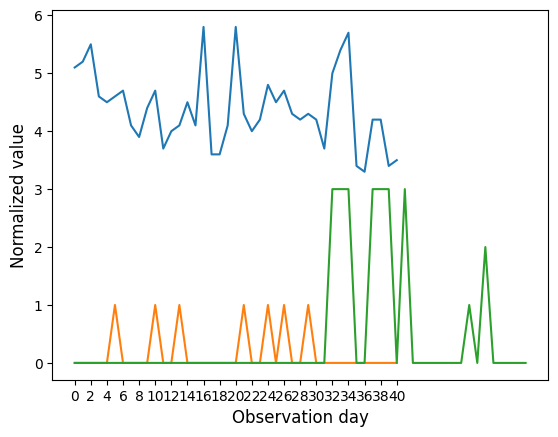

In [255]:
#visualization
xpoints = []
for ipx in range(0,len(x['URO'][0:41])):
    if (ipx%2 == 0):
        xpoints.append(ipx)

plt.figure()
plt.plot(range(0,len(x['Глюкоза'][0:41])), x['Глюкоза'][0:41], label='Нижнее')
plt.plot(range(0,len(x['KET'][0:41])), x['KET'][0:41], label= "Верхнее")
plt.plot(range(0,len(x['GLU'])), x['GLU'], label= 'GLU')
plt.xlabel("Observation day", fontsize=12, labelpad=None, loc=None)
plt.xticks(xpoints)
plt.ylabel("Normalized value", fontsize=12, labelpad=None, loc=None)
#plt.legend()
plt.show()

In [357]:
#test sample generation
n_samples = 40
gp = []
n1 = 0
n2 = 0
n3 = 0
for gpi in range(n_samples*3):
    m = random.choices([0,1,2],[1,3,1])[0]
    if (m == 0):
        gp.append(random.randint(1,13))
        n1 += 1
    if (m == 1):
        gp.append(random.randint(14,26))
        n2 += 1
    if (m == 2):
        gp.append(random.randint(27,40))
        n3 += 1
norma1 = (n1//3)+1
norma2 = n2//3
norma3 = n3//3
alert1 = (n1//3)+1
alert2 = n2//3
alert3 = n3//3
patho1 = n1 - norma1 - alert1
patho2 = n2 - norma2 - alert2
patho3 = n3 - norma3 - alert3
norm_x_test1 = NVG(1,norma1)
norm_x_test2 = NVG(2,norma2)
norm_x_test3 = NVG(3,norma3)
alert_x_test1 = AVG(1,alert1)
alert_x_test2 = AVG(2,alert2)
alert_x_test3 = AVG(3,alert3)
pathological_x_test1 = PVG(1,patho1)
pathological_x_test2 = PVG(2,patho2)
pathological_x_test3 = PVG(3,patho3)
y_test = np.hstack((np.zeros(len(norm_x_test1)),np.ones(len(alert_x_test1)),np.ones(len(pathological_x_test1))*2,np.zeros(len(norm_x_test2)),np.ones(len(alert_x_test2)),np.ones(len(pathological_x_test2))*2,np.zeros(len(norm_x_test3)),np.ones(len(alert_x_test3)),np.ones(len(pathological_x_test3))*2))
y_test = pd.DataFrame(y_test)
y_test.columns = ['Класс']
x_test = pd.concat([norm_x_test1,alert_x_test1,pathological_x_test1, norm_x_test2, alert_x_test2, pathological_x_test2, norm_x_test3, alert_x_test3, pathological_x_test3],ignore_index=True)
x_test = pd.concat([x_test,y_test],axis=1)
gp = pd.DataFrame(gp).sort_values(by=0,ascending=True,ignore_index=True)
gp.columns = ['Неделя_беременности']
trainer = pd.concat([x_test, gp],axis=1)
trainer = trainer.sample(frac=1, ignore_index=True)
y_test = trainer['Класс']
gp = trainer['Неделя_беременности']
x_test = trainer.drop('Класс', axis=1)
x_test = x_test.drop('Неделя_беременности', axis=1)
print(norma1+norma2+norma3,alert1+alert2+alert3,patho1+patho2+patho3)

40 40 40


In [321]:
#модуль функций для обучения и классификации
def train_prep(trimester, n_train_sample):
    x_train = pd.concat([NVG(trimester, n_train_sample), AVG(trimester, n_train_sample), PVG(trimester, n_train_sample)])
    y_train = pd.concat([pd.DataFrame(np.zeros(n_train_sample)),pd.DataFrame(np.ones(n_train_sample)),pd.DataFrame(np.ones(n_train_sample)*2)])
    y_train.columns = ['Класс']
    train_sample = pd.concat([x_train, y_train], axis=1)
    train_sample = train_sample.sample(frac=1, ignore_index=True)
    y_train = train_sample['Класс']
    x_train = train_sample.drop('Класс', axis=1)
    return x_train, y_train

def predict_with_gp(x, models, gestation_period):
    y_pred = []
    model1 = models[0]
    model2 = models[1]
    model3 = models[2]
    for i in range(len(gestation_period)):
        if (gestation_period[i]<14):
            y_pred.append(model1.predict(np.array(x.iloc[i]).reshape(1,-1))[0])
        if (gestation_period[i]>=14 and gestation_period[i]<=26):
            y_pred.append(model2.predict(np.array(x.iloc[i]).reshape(1,-1))[0])
        if (gestation_period[i]>26):
            y_pred.append(model3.predict(np.array(x.iloc[i]).reshape(1,-1))[0])
    return y_pred

def classify(model_type:str, x, y, gestation_period):
    if model_type not in ['SingleTree','RandomForest','XGBoost']:
        raise ValueError("Выбранная модель не поддерживается. Выберите из списка: SingleTree, RandomForest, XGBoost")
    n_train_sample = 1000
    x_train1, y_train1 = train_prep(1, n_train_sample)
    x_train2, y_train2 = train_prep(2, n_train_sample)
    x_train3, y_train3 = train_prep(3, n_train_sample)
    if (model_type == 'SingleTree'):
        model1=tree.DecisionTreeClassifier(criterion="gini")
        model2=tree.DecisionTreeClassifier(criterion="gini")
        model3=tree.DecisionTreeClassifier(criterion="gini")
        model1.fit(x_train1,y_train1)
        model2.fit(x_train2,y_train2)
        model3.fit(x_train3,y_train3)
        y_pred = predict_with_gp(x, [model1, model2, model3], gestation_period)
    if (model_type == 'RandomForest'):
        model1=ensemble.RandomForestClassifier()
        model2=ensemble.RandomForestClassifier()
        model3=ensemble.RandomForestClassifier()
        model1.fit(x_train1,y_train1)
        model2.fit(x_train2,y_train2)
        model3.fit(x_train3,y_train3)
        y_pred = predict_with_gp(x, [model1, model2, model3], gestation_period)
    if (model_type == 'XGBoost'):
        model1=XGBClassifier(seed=0)
        model2=XGBClassifier(seed=0)
        model3=XGBClassifier(seed=0)
        model1.fit(x_train1,y_train1)
        model2.fit(x_train2,y_train2)
        model3.fit(x_train3,y_train3)
        y_pred = predict_with_gp(x, [model1, model2, model3], gestation_period)
    counter = 0
    for i in range(len(y)):
        if (y_pred[i] == y[i]):
            counter += 1
    accuracy = metrics.accuracy_score(y, y_pred)
    print(f'{counter}/{len(y)}')
    print(f'Точность: {accuracy}')
    print(metrics.classification_report(y, y_pred))
    print(metrics.confusion_matrix(y, y_pred))

In [358]:
#апробация
#gp = x['Неделя_беременности']
#y_test = x['Класс']
#x_test = x.loc[:, 'Боль_внизу_живота':'Глюкоза']
classify('XGBoost', x_test, y_test, gp)

119/120
Точность: 0.9916666666666667
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       0.98      1.00      0.99        40
         2.0       1.00      0.97      0.99        40

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

[[40  0  0]
 [ 0 40  0]
 [ 0  1 39]]


In [355]:
#training
model=tree.DecisionTreeClassifier(criterion="gini")
model.fit(x_train,y_train)
#tree.plot_tree(model)
#x_test = df[14:26]
#y_test = x_test['Класс']
#x_test = x_test.drop('Класс',axis=1)
#x_test = x_test.drop('Неделя_беременности',axis=1)
y_pred = model.predict(x_test) #.iloc[[0]]))
#counter = 0
#for iterator in range(len(x_test)):
#    if (model.predict(x_test)[iterator] == y_test[iterator]):
#        counter += 1
accuracy = metrics.accuracy_score(y_test, y_pred) #counter/len(x_test)
#print(f'{counter}/{len(x_test)}')
print(y_pred)
print(accuracy)
metrics.confusion_matrix(y_test, y_pred)

[2. 1. 2. 2. 0. 2. 2. 0. 2. 1. 1. 2. 1. 1. 2. 0. 2. 1. 1. 1. 1. 0. 1. 0.
 2. 2. 0. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 0. 1. 0. 2. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 2. 0. 2. 0. 1. 1. 2. 2. 1. 0. 1. 2. 1. 1. 0. 1. 2. 2.
 2. 2. 1. 2. 2. 0. 1. 0. 0. 2. 2. 2. 2. 0. 2. 1. 1. 0. 2. 0. 1. 0. 1. 2.
 1. 0. 1. 0. 1. 0. 2. 2. 2. 0. 2. 0. 1. 1. 2. 1. 1. 2. 1. 2. 0. 2. 0. 0.]
0.8583333333333333


array([[31,  9,  0],
       [ 0, 35,  5],
       [ 0,  3, 37]])

In [329]:
#saving model
dump(model, 'pregnant_classification_model.joblib')

['pregnant_classification_model.joblib']

In [288]:
#gradient boosting
xgbc = XGBClassifier(seed=0)
xgbc.fit(x_train, y_train)
xgbc_pred_res = xgbc.predict(x_test)
xgbc_accuracy = metrics.accuracy_score(y_test, xgbc_pred_res)
print(f'xgbc accuracy: {xgbc_accuracy}')
print(xgbc_pred_res)
metrics.confusion_matrix(y_test, xgbc_pred_res)

xgbc accuracy: 0.9166666666666666
[0 1 1 0 1 0 0 2 0 1 1 1 2 1 1 1 2 2 0 1 2 0 0 1 0 2 2 0 2 0 1 2 0 2 2 0 0
 1 1 1 1 0 1 1 0 0 0 0 1 2 2 2 1 2 0 2 0 0 2 1 1 1 2 2 2 0 0 0 2 2 2 2 2 2
 2 0 0 2 1 1 1 2 2 1 2 2 0 1 1 1 0 2 1 0 0 2 2 0 1 1 1 2 1 1 0 2 2 1 0 1 1
 2 1 2 0 1 1 1 1 1]


array([[35,  4,  1],
       [ 0, 38,  2],
       [ 0,  3, 37]])

In [292]:
#random forest
rf_model = ensemble.RandomForestClassifier()
rf_model.fit(x_train,y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)
print(f'rf accuracy: {rf_accuracy}')
print(rf_pred)
metrics.confusion_matrix(y_test, rf_pred)

rf accuracy: 0.9166666666666666
[0. 1. 1. 0. 1. 0. 0. 2. 0. 2. 1. 1. 2. 1. 1. 1. 2. 2. 0. 1. 2. 0. 0. 1.
 0. 2. 2. 0. 2. 0. 1. 2. 0. 2. 2. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 2. 1. 1. 2. 1. 2. 0. 2. 0. 0. 2. 1. 1. 1. 2. 2. 2. 0. 0. 0. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 2. 1. 1. 1. 2. 1. 1. 2. 2. 0. 1. 1. 1. 0. 2. 1. 0. 0. 2.
 2. 0. 1. 1. 1. 2. 1. 2. 0. 2. 2. 1. 0. 1. 1. 2. 1. 2. 0. 2. 1. 1. 1. 1.]


array([[35,  5,  0],
       [ 0, 37,  3],
       [ 0,  2, 38]])

In [63]:
from mlxtend.plotting import plot_decision_regions
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_names, title=None):
    feature1_name = feature_names[0] 
    feature2_name = feature_names[1]
    X_feature_columns = np.vstack((X[feature1_name].values, X[feature2_name].values))
    print(X_feature_columns)
    X_train_feature_columns = np.vstack((X_train[feature1_name].values, X_train[feature2_name].values))
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

feature_names = ['GLU', 'Глюкоза']
title2 = 'XGBClassifier surface'
decision_boundary_plot(x_test, y_test, x_train, y_train, xgbc, feature_names, title2)

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  2.  0.  2.  0.  0.  0.  1.
  0.  1.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  1.
  1.  0.  0.  0.  2.  0.  2.  0.  1.  2.  0.  0. ]
 [4.5 4.4 5.3 4.7 4.8 5.5 5.2 4.2 4.4 4.4 4.6 4.6 4.2 4.9 5.3 5.3 4.3 5.2
  4.1 4.5 4.8 4.3 4.8 5.1 4.8 4.7 4.3 4.3 5.  4.5 5.4 4.  5.  5.4 4.6 4.9
  4.3 4.5 4.5 4.9 5.1 4.4 4.4 4.1 4.8 5.5 4.  4.6 5.1 5.3 4.1 4.9 4.7 5.2
  4.6 4.8 5.  4.5 4.1 3.9 4.6 4.5 4.6 3.8 4.5 4.1 4.9 4.  5.  4.4 3.8 5.
  5.7 5.4 5.  4.4 4.5 5.1 4.6 4.5 5.4 5.4 4.8 4.1 4.5 4.3 5.5 4.3 4.1 4.4
  4.7 4.3 4.2 4.1 4.4 3.7 4.8 4.8 4.  4.9 5.5 4.9 4.5 4.8 4.9 5.3 4.  4.5
  5.1 4.1 4.2 5.5 6.5 4.6 4.1 5.1 5.5 5.  5.5 3.7]]


XGBoostError: [19:37:54] C:\actions-runner\_work\xgboost\xgboost\include\xgboost/objective.h:105: multioutput is not supported by the current objective function